<a href="https://colab.research.google.com/github/pratyaksh12/Computer_Vision_and_CNN/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing torch
import torch
from torch import nn

#import torchvision modules
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#data visualisation
import matplotlib.pyplot as plt

In [ ]:
#impoort data from FashionMNIST
train_data = datasets.FashionMNIST(root = 'root', train = True, transform = ToTensor(), target_transform= None, download = True)
test_data = datasets.FashionMNIST(root = 'root', train = False, transform = ToTensor(), target_transform= None, download = True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]


Extracting root/FashionMNIST/raw/train-images-idx3-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 309kB/s]


Extracting root/FashionMNIST/raw/train-labels-idx1-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.92MB/s]


Extracting root/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.63MB/s]


Extracting root/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to root/FashionMNIST/raw



(-0.5, 27.5, 27.5, -0.5)

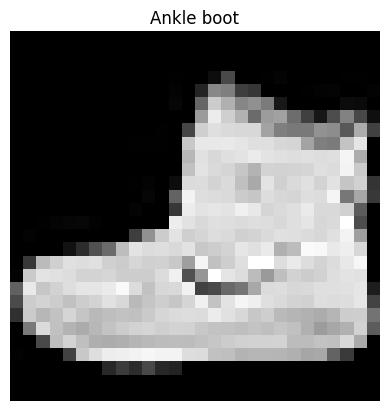

In [ ]:
#visualising the data

image, label = train_data[0]

plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(train_data.classes[label])
plt.axis(False)

In [ ]:
##There are a total of 60000 such samples for training and 10000 for testing

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
#import dataloader and load the data into batches
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, BATCH_SIZE, True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, False)

In [ ]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cpu'

In [ ]:
##Create a normal model

class ModelFashionMNIST1(nn.Module):
  def __init__(self, input_features, output_features, hidden_features):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_features, out_features= hidden_features),
        nn.ReLU(),
        nn.Linear(in_features= hidden_features, out_features = hidden_features),
        nn.ReLU(),
        nn.Linear(in_features= hidden_features, out_features = output_features)
    ).to(device)

  def forward(self, x):
    return self.layer_stack(x)

model_1 = ModelFashionMNIST1(28 * 28, 10, 10)

In [ ]:
import requests
from pathlib import Path

if Path("python_helper.py").is_file():
  print(f"File already exists")
else:
  with open("python_helper.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    f.write(request.content)
    f.close()
    print("File cerated check side folders in the left")

File already exists


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

In [ ]:
from tqdm.auto import tqdm
from python_helper import accuracy_fn
epochs = 3

for epoch in tqdm(range(epochs)):

  total_loss, acc = 0, 0
  for batch, (X,y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)
    #model to train
    model_1.train()

    #Forward pass
    y_logits = model_1(X)

    loss = loss_fn(y_logits, y)
    total_loss += loss.item()
    acc += accuracy_fn(y, torch.argmax(y_logits, dim = 1))
    #zero gradding
    optimizer.zero_grad()

    #backward pass
    loss.backward()

    #gradient descent
    optimizer.step()

  #Tetsting

  test_loss = 0

  model_1.eval()
  with torch.inference_mode():

    for X_test, y_test in test_dataloader:

      X_test = X_test.to(device)
      y_test = y_test.to(device)

      #Forward pass
      y_logits_test = model_1(X_test)

      #Calculate loss
      test_loss += loss_fn(y_logits_test, y_test)

  print(f"Epoch = {epoch + 1}, Loss = {total_loss / len(train_dataloader) :.4f}, Test Loss = {test_loss / len(test_dataloader) :.4f}, acc = {acc / len(train_dataloader) :.4f}")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch = 1, Loss = 0.6938, Test Loss = 0.5169, acc = 74.3600
Epoch = 2, Loss = 0.4888, Test Loss = 0.5019, acc = 82.4667
Epoch = 3, Loss = 0.4529, Test Loss = 0.4634, acc = 83.9083


In [ ]:
model_stat = {}
model_stat['model_1'] = 83.9083

In [ ]:
##Building a CNN

class ModelFashionMNIST2(nn.Module):
  def __init__(self, input_features, output_features, hidden_features):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_features,
                  out_channels = hidden_features,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_features,
                  out_channels = hidden_features,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_features,
                  out_channels = hidden_features,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_features,
                  out_channels = hidden_features,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.decision = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_features * 7 * 7,
                  out_features = output_features
                  )
    ).to(device)

  def forward(self, x):
    # print(x.shape)
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.decision(x)
    return x

In [ ]:
model_2 = ModelFashionMNIST2(1, 10, 10)

In [ ]:
#Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [ ]:
#Testing with a dummy data and determinig the decision shape for input

dummy = torch.rand(size = (1,1,28,28))

model_2(dummy)

tensor([[-0.0604,  0.0073, -0.0752, -0.0586, -0.0097, -0.1020,  0.0198,  0.0236,
         -0.0429,  0.0465]], grad_fn=<AddmmBackward0>)

In [ ]:
epochs = 3

for epoch in tqdm(range(epochs)):

  total_loss, acc = 0, 0
  for batch, (X,y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)
    #model to train
    model_2.train()

    #Forward pass
    y_logits = model_2(X)

    loss = loss_fn(y_logits, y)
    total_loss += loss.item()
    acc += accuracy_fn(y, torch.argmax(y_logits, dim = 1))
    #zero gradding
    optimizer.zero_grad()

    #backward pass
    loss.backward()

    #gradient descent
    optimizer.step()

  #Tetsting

  test_loss = 0

  model_2.eval()
  with torch.inference_mode():

    for X_test, y_test in test_dataloader:

      X_test = X_test.to(device)
      y_test = y_test.to(device)

      #Forward pass
      y_logits_test = model_2(X_test)

      #Calculate loss
      test_loss += loss_fn(y_logits_test, y_test)

  print(f"Epoch = {epoch + 1}, Loss = {total_loss / len(train_dataloader) :.4f}, Test Loss = {test_loss / len(test_dataloader) :.4f}, acc = {acc / len(train_dataloader) :.4f}")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch = 1, Loss = 0.6561, Test Loss = 0.4395, acc = 75.9650
Epoch = 2, Loss = 0.3773, Test Loss = 0.4024, acc = 86.4267
Epoch = 3, Loss = 0.3342, Test Loss = 0.3413, acc = 87.8883


In [ ]:
model_stat['model_2'] = 87.8883

In [ ]:
##accuraccy of cnn -> 87.8883
##accuracy of a conventional neural network = 83.9083